In [1]:
#import and fix the seed

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42    #Random generator seed 

In [3]:
#import dataset
from keras.datasets import mnist

#loading the dataset
(train_x, train_y), (test_x, test_y) = mnist.load_data()

2024-02-15 10:44:18.318994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#transform the data from 3D to 2D array 
nsamples, nx, ny = train_x.shape    
nsamples_1, nx_1, ny_1 = test_x.shape         
train_x = train_x.reshape((nsamples,nx*ny))   
test_x = test_x.reshape(nsamples_1,nx_1*ny_1)

In [5]:
#transform the value in the range [0,1] and divide in test/train set
from sklearn.preprocessing import MinMaxScaler

train_x = MinMaxScaler().fit_transform(train_x)
test_x = MinMaxScaler().fit_transform(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [6]:
#Implementing PCA reduction 
from sklearn.decomposition import PCA

pca = PCA(n_components = 64)
pca1 = PCA(n_components = 64)
pca.fit(train_x)
train_x = pca.transform(train_x)
pca1.fit(test_x)
test_x = pca1.transform(test_x)

print(train_x.shape)
print(test_x.shape)

(60000, 64)
(10000, 64)


In [7]:
#Select only 0's and 1's for the first try

def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

train_x, train_y = filter_01(train_x, train_y)  #Filters the train set
test_x, test_y = filter_01(test_x, test_y)      #Filters the test set

train_x.shape

(12665, 64)

In [8]:
#Test only in 1/50 of the dataset

train_x = train_x[::50]
train_y = train_y[::50]
test_x = test_x[::50]
test_y = test_y[::50]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(254, 64)
(254,)
(43, 64)
(43,)


Choose between RealAmplitudes or EfficientSU2 for the ansatz

In [66]:
#Define the ansatz and the number of repetitions
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=3) 

In [40]:
#Define the ansatz and the number of repetitions
""" def ansatz(num_qubits):
    return EfficientSU2(num_qubits, reps=1) """

In [67]:
#define the autoencoder circuit
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")   
    cr = ClassicalRegister(1, "c")                                                                  
    circuit = QuantumCircuit(qr, cr)    
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True) 
    circuit.barrier()   
    auxiliary_qubit = num_latent + 2 * num_trash    
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):  
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)   

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0]) 
    return circuit

We have 64 features, thus we need 6 qubits, we want to compress this into 4 qubits

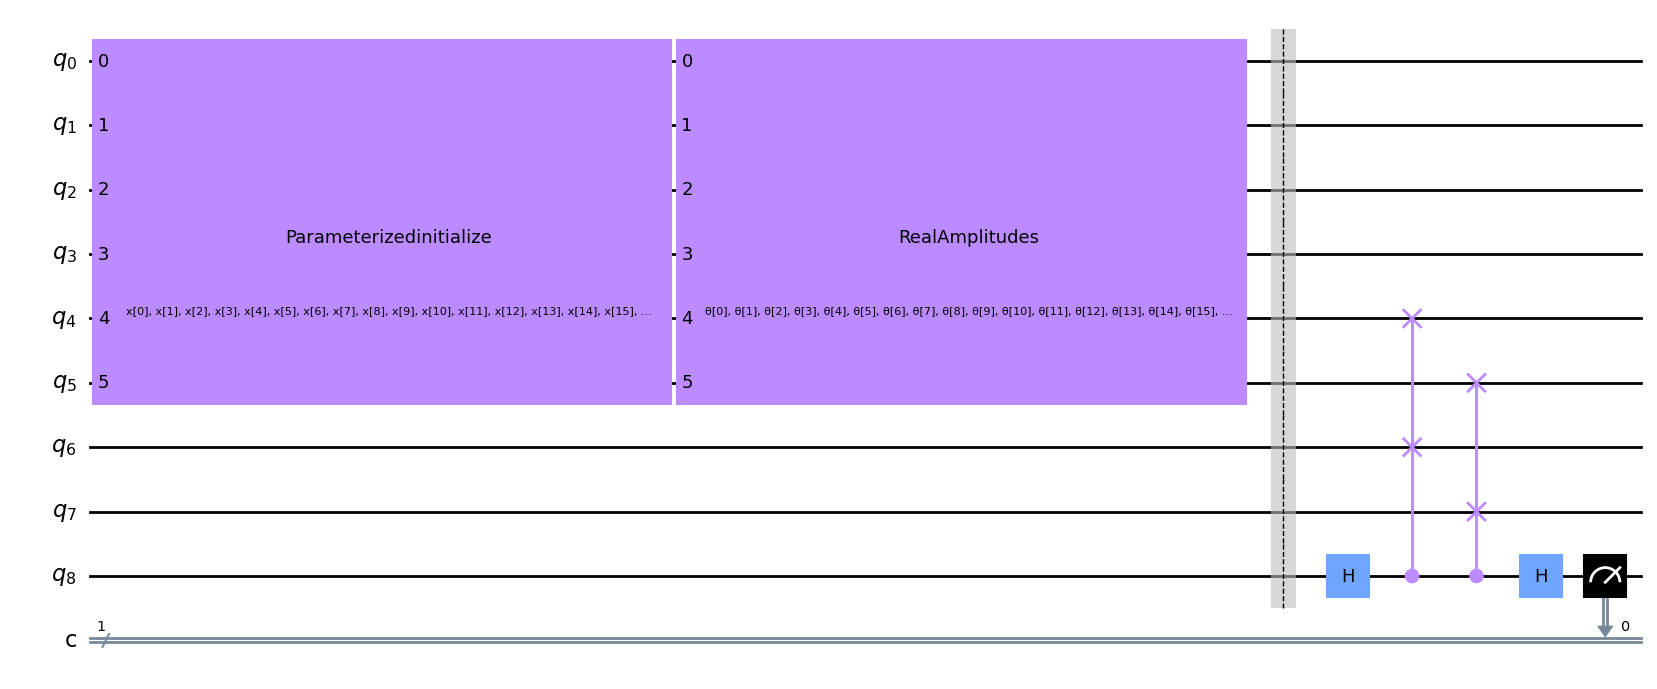

In [68]:
num_latent = 4
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))    
ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl", style='clifford')

In [69]:
#interpreter function for the QNN
def parity(x):
    return f"{bin(x)}".count("1") % 2

#create the QNN
qnn = SamplerQNN(
    circuit=qc,                       #The parametrized quantum circuit that generates the samples of this network. 
    input_params=fm.parameters,       #The parameters of the circuit corresponding to the input.
    weight_params=ae.parameters,      #The parameters of the circuit corresponding to the trainable weights.
    interpret=parity,
    output_shape=2,
)

In [38]:
#cost function to minimize in the training process
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_x, params_values)    
    cost = np.sum(probabilities[:, 1]) / train_x.shape[0]  

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

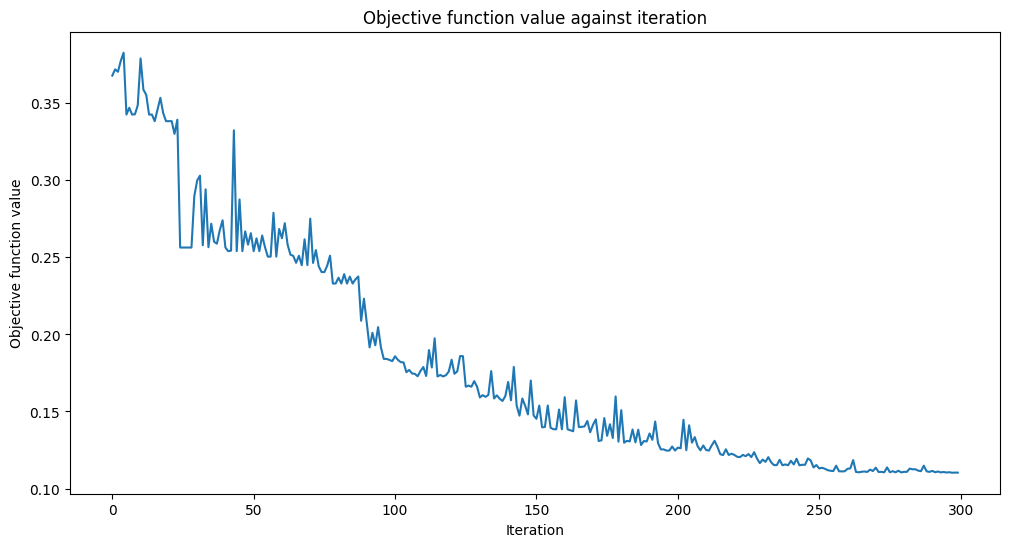

Fit in 1176.28 seconds


In [39]:
#implementing the optimization

opt = COBYLA(maxiter=300)
initial_point = algorithm_globals.random.random(ae.num_parameters)  

objective_func_vals = []

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0 = initial_point)
elapsed = time.time() - start 
print(f"Fit in {elapsed:0.2f} seconds")

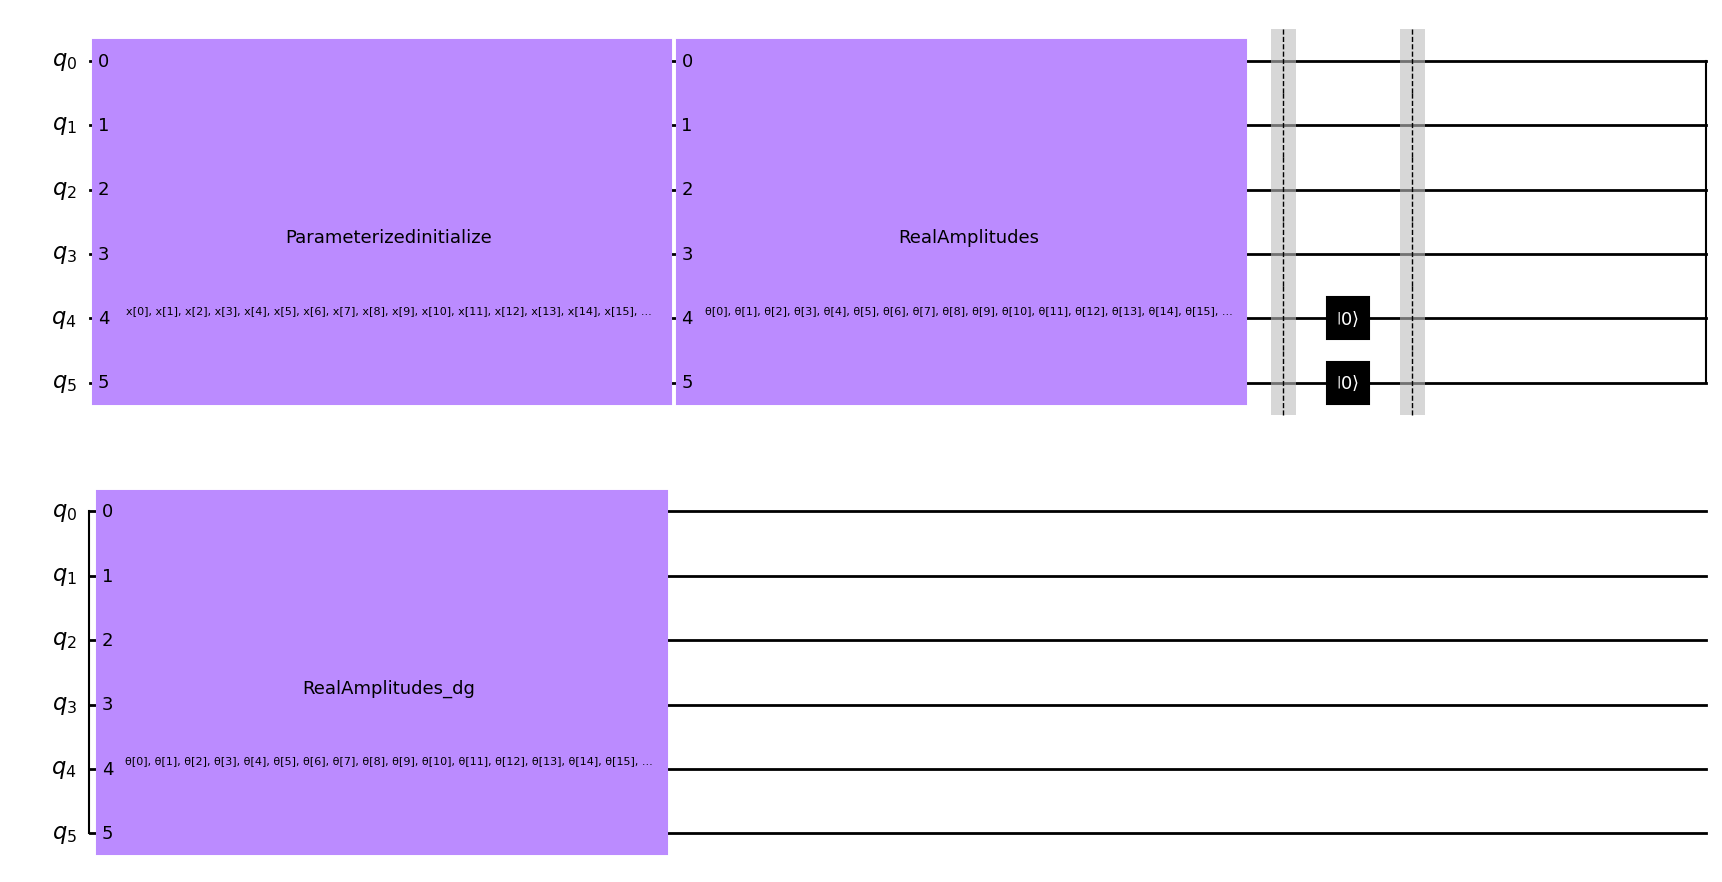

In [70]:
# Make the encoder followed by the decoder

test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(5)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw('mpl', style='clifford')

In [71]:
#import previous trained parameters
train_param = np.loadtxt("/Users/moseguerini/Desktop/QA_parameters/RA_4rep_parameters.txt")
print(train_param)

[ 1.44592400e+00  1.73314540e+00  1.11495448e+00  2.18980995e+00
  1.56681855e+00  1.58004925e+00  4.82839466e-01  7.45608216e-01
  1.34719896e+00  1.56133466e+00  1.46471956e-03  3.11304510e+00
 -2.33621119e-01  8.15991998e-01  3.69306724e-01  6.10461080e-01
  3.22796355e+00 -8.67231147e-03  2.89632345e-01  9.29820668e-01
 -3.71843155e-02 -1.33403646e+00  1.58922378e+00  1.58901257e+00]


In [74]:
# Compute the fidelity between the original state and the decoded state
""" !!! If we calculate the fidelity using saved parameters use train_param, else use opt_result.x !!! """

test_images = train_x[:]
test_labels = train_y[:]

count_fidelity = 0
count = 0
count_fidelity_test = 0
count_test = 0

for image in test_images:      
    original_qc = fm.assign_parameters(image)           
    original_sv = Statevector(original_qc).data         

    param_values = np.concatenate((image, train_param))   #choose opt_result.x / train_param  
    output_qc = test_qc.assign_parameters(param_values)     
    output_sv = Statevector(output_qc).data                  

    fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    count_fidelity = count_fidelity + fidelity.real
    count = count +1
    #print("Fidelity of our Output State with our Input State: ", fidelity.real)

for image, label in zip(test_x, test_y):      
    original_qc = fm.assign_parameters(image)           
    original_sv = Statevector(original_qc).data        

    param_values = np.concatenate((image, train_param))    #choose opt_result.x / train_param 
    output_qc = test_qc.assign_parameters(param_values)    
    output_sv = Statevector(output_qc).data                  

    fidelity_test = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    count_fidelity_test = count_fidelity_test + fidelity_test.real
    count_test = count_test +1
    #print("Fidelity of our Output State with our Input State: ", fidelity.real)

print('Mean Fidelity Train: ', count_fidelity/count)
print('Mean Fidelity Test: ', count_fidelity_test/count_test)

Mean Fidelity Train:  0.7433039650632786
Mean Fidelity Test:  0.7741777559684594


In [45]:
# Create and save the results in a txt

f = open('RA_4rep.txt', 'w')    #change name of the file                                    
print('Optimized Parameters: \n', opt_result.x, '\n' , file=f)
print('Mean Fidelity Train: ', count_fidelity/count, '\n' , file=f)
print('Mean Fidelity Test: ', count_fidelity_test/count_test, '\n' , file=f)
print(f'Training Time: {elapsed:0.2f} seconds"', '\n' , file=f)
f.close()